In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [3]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import healpy as hp

import nlopt

import gc

%load_ext autoreload
%autoreload 2

from dataloader import get_data, get_data_3d
from sklearn.model_selection import train_test_split


In [4]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [5]:
#labels = ['x', 'y', 'z', 'time', 'azimuth','zenith', 'energy']
labels = ['azimuth','zenith']
reco_labels = labels#[:-1]

Xs = []
ys = []
rs = []


for i in range(10):
    #fname = '../test_data/oscNext_genie_level3_v01.03_pass2.120000.000%s0.hdf5'%('%s'%i).zfill(2)
    fname = '../test_data/oscNext_genie_level3_v01.03_pass2.140000.000%s00.hdf5'%i
    try:
        X, y, r = get_data_3d(
            fname,
            labels = labels,
            reco_labels = reco_labels,
            N_events=None,
            min_pulses=10,
            )
        Xs.append(X)
        ys.append(y)
        rs.append(r)
    except OSError:
        print('Skipping file %s'%fname)
        #raise Exception

X_data = np.concatenate(Xs)
X_params = np.concatenate(ys)
r = np.concatenate(rs)
    
r = np.nan_to_num(r)
    
N_events, N_channels, N_features = X_data.shape
_, N_labels = X_params.shape



Skipping file ../test_data/oscNext_genie_level3_v01.03_pass2.140000.000000.hdf5


100%|██████████| 9082/9082 [00:23<00:00, 389.96it/s]


In [6]:
X_data_train, X_data_test, X_params_train, X_params_test, r_train, r_test = train_test_split(X_data, X_params, r, test_size=0.1, random_state=42)

In [7]:
#energy_idx = labels.index('energy')

#X_params_train[:, energy_idx] = np.log(X_params_train[:, energy_idx])
#X_params_test[:, energy_idx] = np.log(X_params_test[:, energy_idx])

In [8]:
azimuth_idx = labels.index('azimuth')
zenith_idx = labels.index('zenith')


class trafo(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(trafo, self).__init__()
        self.num_outputs = num_outputs

    def call(self, input):
        
        dir_x = tf.math.sin(input[:, zenith_idx]) * tf.math.cos(input[:, azimuth_idx])
        dir_y = tf.math.sin(input[:, zenith_idx]) * tf.math.sin(input[:, azimuth_idx])
        dir_z = tf.math.cos(input[:, zenith_idx])

        out =  tf.concat([input[:,:min(azimuth_idx, zenith_idx)], dir_x[:, tf.newaxis], dir_y[:, tf.newaxis], dir_z[:, tf.newaxis], input[:,1+max(azimuth_idx, zenith_idx):]], axis=1)
        
        return out

In [9]:
activation='elu'


# Data network

inputs_data = tf.keras.Input(shape=(N_channels, N_features), )

h = tf.keras.layers.Reshape((86, 60 * N_features))(inputs_data)
h = tf.keras.layers.Dropout(0.01)(h)
ic = tf.keras.layers.Lambda(lambda x: x[:, :78])(h)
dc = tf.keras.layers.Lambda(lambda x: x[:, 78:])(h)

n1 = 64
h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n1, activation=activation, input_shape=(60 * N_features,)), input_shape=(78, 60 * N_features))(ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n1, activation=activation, input_shape=(60 * N_features,)), input_shape=(8, 60 * N_features))(dc)

h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(n1,)), input_shape=(78,n1))(h_ic)
h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(n1,)), input_shape=(8,n1))(h_dc)

h = tf.keras.layers.Concatenate(axis=1)([h_ic, h_dc])

h = tf.keras.layers.Flatten(input_shape=(86, 16))(h)

h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)
h = tf.keras.layers.Dense(32, activation=activation)(h)
outputs_data = tf.keras.layers.Dense(32, activation=activation)(h)

model_data = tf.keras.Model(inputs=inputs_data, outputs=outputs_data)


# # Data network CNN

# inputs_data = tf.keras.Input(shape=(N_channels, N_features), )

# h = tf.keras.layers.Reshape((86, 60, N_features, 1))(inputs_data)

# h = tf.keras.layers.Dropout(0.01)(h)
# ic = tf.keras.layers.Lambda(lambda x: x[:, :78])(h)
# dc = tf.keras.layers.Lambda(lambda x: x[:, 78:])(h)

# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (5, N_features), activation=activation, input_shape=(60, N_features,)), input_shape=(78, 60, N_features))(ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (5, N_features), activation=activation, input_shape=(60, N_features,)), input_shape=(8, 60, N_features))(dc)

# h_ic = tf.keras.layers.Reshape((78, 56, 64))(h_ic)
# h_dc = tf.keras.layers.Reshape((8, 56, 64))(h_dc)

# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling1D((2,), input_shape=(56,)), input_shape=(78, 56))(h_ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling1D((2,), input_shape=(56,)), input_shape=(8, 56))(h_dc)


# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, (2, ), activation=activation, input_shape=(28,)), input_shape=(78, 28))(h_ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(32, (2, ), activation=activation, input_shape=(28,)), input_shape=(8, 28))(h_dc)


# #h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (5,3), activation=activation, input_shape=(28, 5,)), input_shape=(78, 28, 5))(h_ic)
# #h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, (5,3), activation=activation, input_shape=(28, 5,)), input_shape=(8, 28, 5))(h_dc)


# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten(input_shape=(28,)), input_shape=(78, 28))(h_ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten(input_shape=(28,)), input_shape=(8, 28))(h_dc)

# h_ic = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(896,)), input_shape=(78,896))(h_ic)
# h_dc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation=activation, input_shape=(896,)), input_shape=(8,896))(h_dc)


# h = tf.keras.layers.Concatenate(axis=1)([h_ic, h_dc])

# h = tf.keras.layers.Flatten(input_shape=(86, 16))(h)

# #h = tf.keras.layers.AveragePooling2D((1,2))(h)

# #h = tf.keras.layers.Conv2D(32, (1, 5), activation=activation)(h)

# #h = tf.keras.layers.AveragePooling2D((1,2))(h)

# #h = tf.keras.layers.Conv2D(32, (1, 5), activation=activation)(h)

# #h = tf.keras.layers.AveragePooling2D((1,2))(h)

# #h = tf.keras.layers.Flatten()(h)

# h = tf.keras.layers.Dense(32, activation=activation)(h)
# h = tf.keras.layers.Dropout(0.01)(h)
# h = tf.keras.layers.Dense(32, activation=activation)(h)
# outputs_data = tf.keras.layers.Dense(32, activation=activation)(h)

# model_data = tf.keras.Model(inputs=inputs_data, outputs=outputs_data)







# Parameters network

p_activation = 'relu'

inputs_params = tf.keras.Input(shape=(N_labels,))

y = trafo(len(labels)+1)(inputs_params)

y = tf.keras.layers.Dense(32, activation=p_activation)(y)
#y = tf.keras.layers.Dense(128, activation=p_activation)(y)
#y = tf.keras.layers.Dense(128, activation=p_activation)(y)
#y = tf.keras.layers.Dense(32, activation=p_activation)(y)
#y = tf.keras.layers.Dropout(0.01)(y)
y = tf.keras.layers.Dense(64, activation=p_activation)(y)
y = tf.keras.layers.Dense(128, activation=p_activation)(y)
y = tf.keras.layers.Dense(64, activation=p_activation)(y)
outputs_params = tf.keras.layers.Dense(32, activation=p_activation)(y)

model_params = tf.keras.Model(inputs=inputs_params, outputs=outputs_params)


combined = tf.keras.layers.Concatenate()([model_data.output, model_params.output])


z = tf.keras.layers.Dense(128, activation="relu")(combined)
#z = tf.keras.layers.Dense(32, activation="relu")(z)
z = tf.keras.layers.Dropout(0.01)(z)
z = tf.keras.layers.Dense(64, activation="relu")(z)
z = tf.keras.layers.Dense(32, activation="relu")(z)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(z)


# our model will accept the inputs of the two branches and
# then output a single value
model = tf.keras.Model(inputs=[model_data.input, model_params.input], outputs=outputs)

model.summary()

loss_history = []
val_loss_history = []

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5160, 7)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 86, 420)      0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 86, 420)      0           reshape[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 78, 420)      0           dropout[0][0]                    
____________________________________________________________________________________________

In [10]:
#optimizer = tf.keras.optimizers.SGD(0.001)
#optimizer = tf.keras.optimizers.RMSprop(0.001, )
#optimizer = tf.keras.optimizers.Nadam(0.001)
optimizer = tf.keras.optimizers.Adam(0.0001)

model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [11]:
del inputs_train
del outputs_train
del inputs_test
del outputs_test
gc.collect()

NameError: name 'inputs_train' is not defined

In [12]:
inputs_train = [np.vstack([X_data_train, X_data_train]),  np.vstack([X_params_train, np.random.permutation(X_params_train)])]
outputs_train = np.concatenate([np.ones(X_data_train.shape[0]), np.zeros(X_data_train.shape[0])])
                
inputs_test = [np.vstack([X_data_test, X_data_test]),  np.vstack([X_params_test, np.random.permutation(X_params_test)])]
outputs_test = np.concatenate([np.ones(X_data_test.shape[0]), np.zeros(X_data_test.shape[0])])

Epoch 1
Train on 148526 samples, validate on 16504 samples
148526/148526 [==============================] - 12s 78us/sample - loss: 0.6935 - val_loss: 0.6931
Epoch 2
Train on 148526 samples, validate on 16504 samples
148526/148526 [==============================] - 9s 57us/sample - loss: 0.6933 - val_loss: 0.6931
Epoch 3
Train on 148526 samples, validate on 16504 samples
148526/148526 [==============================] - 7s 50us/sample - loss: 0.6932 - val_loss: 0.6930
Epoch 4
Train on 148526 samples, validate on 16504 samples
148526/148526 [==============================] - 7s 50us/sample - loss: 0.6930 - val_loss: 0.6927
Epoch 5
Train on 148526 samples, validate on 16504 samples
148526/148526 [==============================] - 10s 68us/sample - loss: 0.6906 - val_loss: 0.6835
Epoch 6
Train on 148526 samples, validate on 16504 samples
148526/148526 [==============================] - 7s 50us/sample - loss: 0.6708 - val_loss: 0.6548
Epoch 7
Train on 148526 samples, validate on 16504 sampl

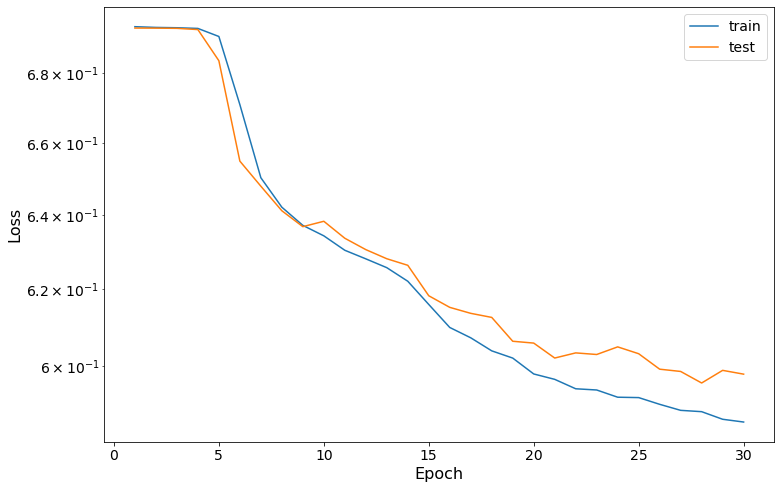

In [13]:
for i in range(30):
    
    #if i%2:
    #    optimizer = tf.keras.optimizers.Adam(0.0001)
    #else:
    #    optimizer = tf.keras.optimizers.RMSprop(0.001)
    #
    #model.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # re-shuffle
    inputs_train[1] = np.vstack([X_params_train, np.random.permutation(X_params_train)])#np.vstack([X_params_train, np.stack([np.random.permutation(X_params_train[:,0]), np.random.permutation(X_params_train[:,1])], axis=1)])
    inputs_test[1] = np.vstack([X_params_test, np.random.permutation(X_params_test)])#np.vstack([X_params_test, np.stack([np.random.permutation(X_params_test[:,0]), np.random.permutation(X_params_test[:,1])], axis=1)])
    
    # sample from flat
#     rand_train_params = np.random.uniform(size=X_params_train.size).reshape(X_params_train.shape)
#     rand_test_params = np.random.uniform(size=X_params_test.size).reshape(X_params_test.shape)
    
#     # zen / az
#     #rand_train_params[:,0] = np.arccos((rand_train_params[:,0] * 2) - 1)
#     #rand_train_params[:,1] *= 2 * np.pi
#     #rand_test_params[:,0] = np.arccos((rand_test_params[:,0]) * 2 - 1)
#     #rand_test_params[:,1] *= 2 * np.pi
    
#     # scale
#     bounds = np.quantile(X_params, [0., 1.], axis=0)
#     delta = np.diff(bounds, axis=0)
#     rand_train_params *= delta
#     rand_test_params *= delta
#     rand_train_params += bounds[0]
#     rand_test_params += bounds[0]

#     inputs_train[1] = np.vstack([X_params_train, rand_train_params])
#     inputs_test[1] = np.vstack([X_params_test, rand_test_params])
    
    gc.collect()

    print('Epoch %i'%(len(loss_history)+1))
    
    model.fit(inputs_train, outputs_train, batch_size=512, epochs=1, validation_data=(inputs_test, outputs_test))

    loss_history.append(model.history.history['loss'])
    val_loss_history.append(model.history.history['val_loss'])
    

fig, ax = plt.subplots(1, 1, figsize=(12,8))
x = np.arange(1, len(loss_history)+1)
ax.plot(x, np.concatenate(loss_history), label='train')
ax.plot(x, np.concatenate(val_loss_history), label='test')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

In [14]:
event_idx = 535 #5697

true_params = X_params_test[event_idx]

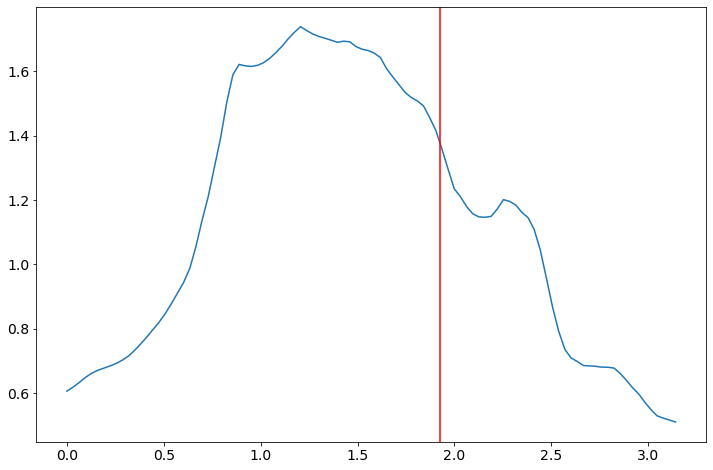

In [15]:
plot_dim = 'zenith'
plot_idx = labels.index(plot_dim)

true_p = true_params[plot_idx]

xs = np.linspace(0, np.pi, 100)
#xs = np.linspace(true_p-30, true_p+30, 100)

params = np.repeat(true_params, xs.shape[0]).reshape(-1, xs.shape[0]).T

params[:, plot_idx] = xs

#ys = np.repeat(true_y, xs.shape[0])

#params = np.stack([xs, ys]).T
data = np.rollaxis(np.repeat(X_data_test[event_idx], params.shape[0]).reshape((X_data_test[event_idx].shape[0], X_data_test[event_idx].shape[1], params.shape[0])),2)

likelihood = model.predict([data, params], batch_size=512)

likelihood /= 1 - likelihood

plt.plot(xs, likelihood)
plt.axvline(true_p, c='r')

#plt.gca().set_xscale('log')

In [16]:
def plot_2d(ax, plot_dim_x, plot_dim_y, N=100, d_x=100, d_y=100):

    plot_idx_x = labels.index(plot_dim_x)
    plot_idx_y = labels.index(plot_dim_y)

    true_p_x = true_params[plot_idx_x]
    true_p_y = true_params[plot_idx_y]

    #xs = np.linspace(0, 2*np.pi, 100)
    if plot_dim_x == 'zenith':
        xs = np.linspace(0, np.pi, N+1)
    elif plot_dim_x == 'azimuth':
        xs = np.linspace(0, 2*np.pi, N+1)
    else:
        xs = np.linspace(true_p_x-d_x, true_p_x+d_x, N+1)

    if plot_dim_y == 'zenith':
        ys = np.linspace(0, np.pi, N+1)
    elif plot_dim_y == 'azimuth':
        ys = np.linspace(0, 2*np.pi, N+1)
    else:
        ys = np.linspace(true_p_y-d_y, true_p_y+d_y, N+1)

    x_edges, y_edges = np.meshgrid(xs,ys)
    
    x_points = 0.5 * (xs[:-1] + xs[1:])
    y_points = 0.5 * (ys[:-1] + ys[1:])
        
    xx, yy = np.meshgrid(x_points,y_points)
    xx = xx.flatten()
    yy = yy.flatten()

    params = np.repeat(true_params, xx.shape[0]).reshape(-1, xx.shape[0]).T

    params[:, plot_idx_x] = xx
    params[:, plot_idx_y] = yy

    data = np.rollaxis(np.repeat(X_data_test[event_idx], params.shape[0]).reshape((X_data_test[event_idx].shape[0], X_data_test[event_idx].shape[1], params.shape[0])),2)

    likelihood = model.predict([data, params], batch_size=512)

    likelihood /= 1 - likelihood

    z = likelihood.reshape((x_points.shape[0], y_points.shape[0]))
    
    im = ax.pcolormesh(x_edges, y_edges, np.log(z) - np.log(np.max(z)), cmap='Spectral_r', )

    ax.axvline(true_p_x, c='r')
    ax.axhline(true_p_y, c='r', label='truth')

    plt.colorbar(im, ax=ax, label=r'learned $\Delta$log-likelihood', )

    ax.contour(x_points, y_points, np.log(z) - np.log(np.max(z)), [-9.21/2, -5.99/2, -4.51/2, -2.3/2], colors='white')

    ax.plot(xx[np.argmax(z)],  yy[np.argmax(z)], marker='*', color='w', lw=0, ms=20, label='MLE')

    try:
        r_idx_x = reco_labels.index(plot_dim_x)
        r_idx_y = reco_labels.index(plot_dim_y)
        ax.plot(r_test[event_idx][r_idx_x],  r_test[event_idx][r_idx_y], marker='o', color='k', lw=0, ms=10, label='SPEFit2')
    except:
        pass

    try:
        ax.plot(x_opt[plot_idx_x],  x_opt[plot_idx_y], marker='D', color='gray', lw=0, ms=10, label='Opt')
    except:
        pass

    #ax.set_xlabel('x position (m)')
    #ax.set_ylabel('y position (m)')

    #ax.set_xlabel('x position (m)')
    #ax.set_ylabel('z position (m)')

    #ax.set_xlabel('azimuth (rad)')
    #ax.set_ylabel('zenith (rad)')

    ax.set_xlabel(plot_dim_x)
    ax.set_ylabel(plot_dim_y)

    ax.legend()

    #plt.savefig('angles_llh_yet_another_cherry_picked_nice_event.png', dpi=150)

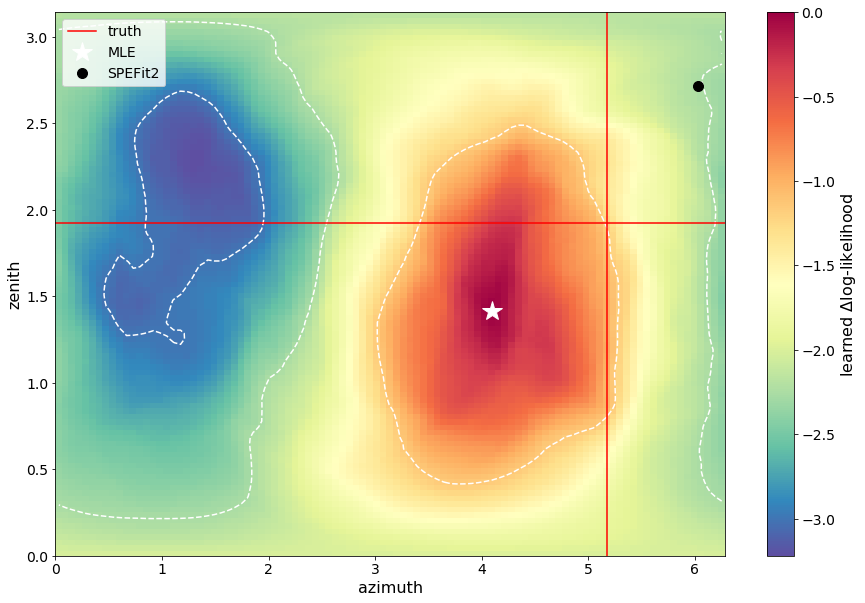

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15,10), squeeze=False)

N=99


plot_2d(ax[0,0], 'azimuth', 'zenith', N=N)


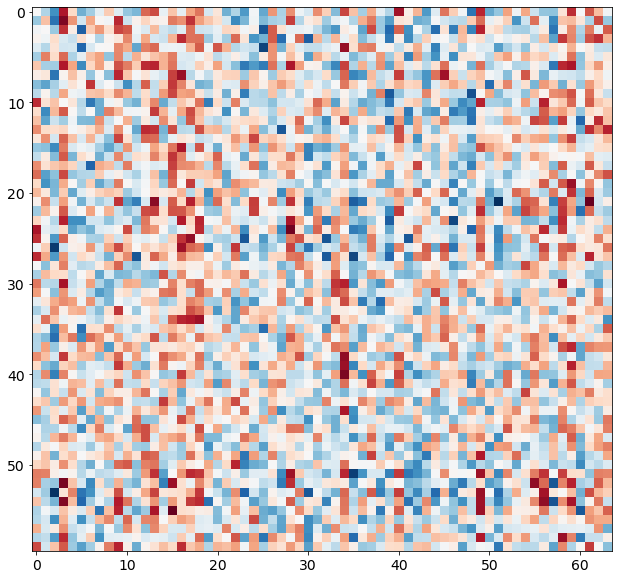

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(25,10), squeeze=False)

A = model.layers[6].weights[0].numpy()
b = model.layers[6].weights[1].numpy()

ax[0,0].imshow(A[:60], cmap='RdBu')

In [36]:
b.shape

(64,)

In [ ]:
icenet_recos = []
mc_truth = []
spe_reco = []


for event_idx in range(1000):

    zen = np.linspace(0, np.pi, 20)
    az = np.linspace(0, 2*np.pi, 20)
    zenzen, azaz = np.meshgrid(zen, az)

    zenzen = zenzen.flatten()
    azaz = azaz.flatten()

    params = np.stack([azaz, zenzen]).T
    data = np.rollaxis(np.repeat(X_data_test[event_idx], params.shape[0]).reshape((X_data_test[event_idx].shape[0], X_data_test[event_idx].shape[1], params.shape[0])),2)

    z = model.predict([data, params], batch_size=512)

    #likelihood /= 1 - likelihood

    reco = [azaz[np.argmax(z)], zenzen[np.argmax(z)]]

    icenet_recos.append(reco)
    mc_truth.append(X_params_test[event_idx])
    spe_reco.append(r_test[event_idx])


In [141]:
icenet_recos = np.array(icenet_recos)
mc_truth = np.array(mc_truth)
spe_reco = np.array(spe_reco)

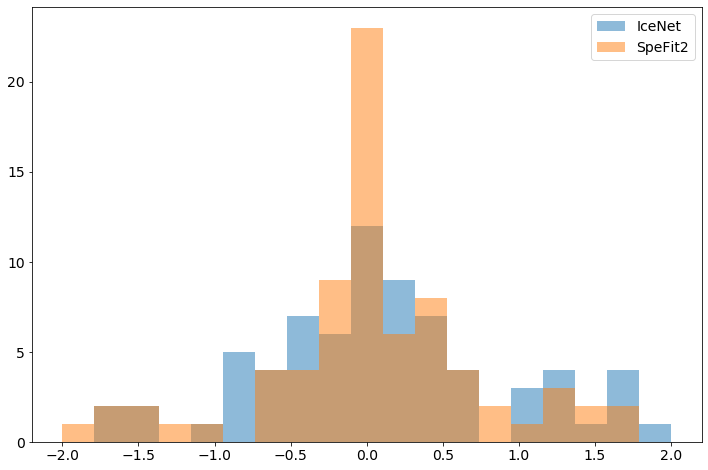

In [142]:
idx = 0

bins = np.linspace(-2, 2, 20)

plt.hist(icenet_recos[:,idx] - mc_truth[:,idx], bins=bins, alpha=0.5, label='IceNet')
plt.hist(spe_reco[:,idx] - mc_truth[:,idx], bins=bins, alpha=0.5, label='SpeFit2')
plt.legend()

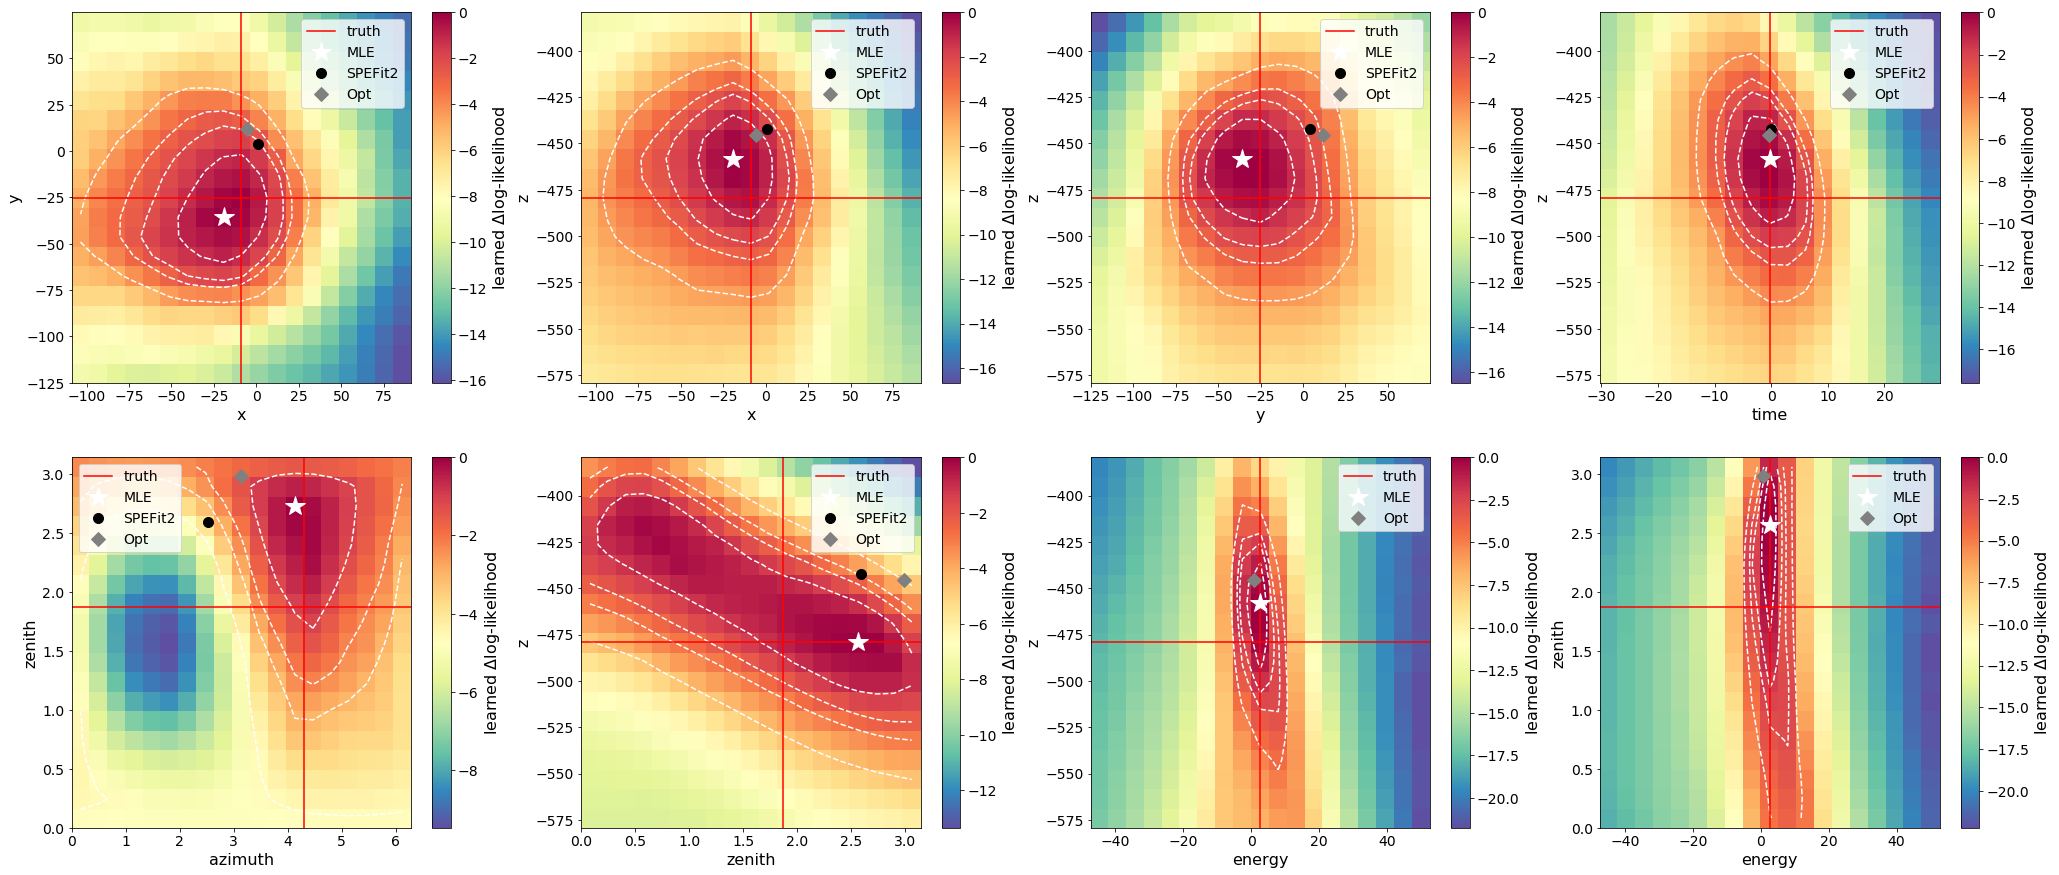

In [414]:
fig, ax = plt.subplots(2, 4, figsize=(35,15), squeeze=False)

N=19

plot_2d(ax[0,0], 'x', 'y', N=N)
plot_2d(ax[0,1], 'x', 'z', N=N)
plot_2d(ax[0,2], 'y', 'z', N=N)
plot_2d(ax[0,3], 'time', 'z', N=N, d_x=30)
plot_2d(ax[1,0], 'azimuth', 'zenith', N=N)
plot_2d(ax[1,1], 'zenith', 'z', N=N)
plot_2d(ax[1,2], 'energy', 'z', N=N, d_x = 50)
plot_2d(ax[1,3], 'energy', 'zenith', N=N, d_x = 50)



In [119]:
fig.savefig('test_2d_scan_2.png')

In [1]:
model

NameError: name 'model' is not defined

Optimizer

In [176]:
NSIDE = 32
#m = hp.ma(np.arange(hp.nside2npix(NSIDE), dtype=np.double))
#mask = np.zeros(hp.nside2npix(NSIDE), dtype=np.bool)
pixel_theta, pixel_phi = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)))
#mask[pixel_theta > np.pi/2] = 1
#m.mask = mask
#hp.mollview(m)

params = np.stack([pixel_phi, pixel_theta]).T

data = np.rollaxis(np.repeat(X_data_test[event_idx], params.shape[0]).reshape((X_data_test[event_idx].shape[0], X_data_test[event_idx].shape[1], params.shape[0])),2)


In [938]:
likelihood = model.predict([data, params], batch_size=512)

likelihood /= 1 - likelihood

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


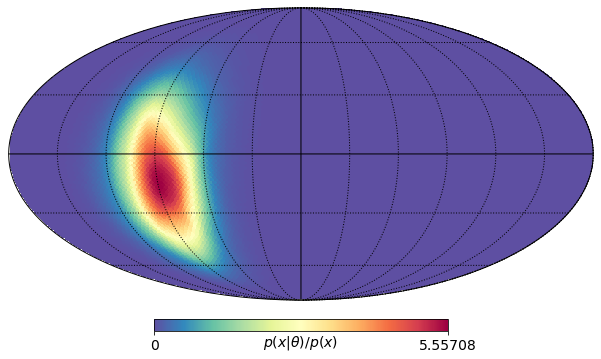

In [983]:
hp.mollview(likelihood.flatten(), cmap='Spectral_r', rot=0, title=None, unit=r'$p(x|\theta)/p(x)$', min=0)
hp.graticule()


In [404]:
data = tf.constant([X_data_test[event_idx]])

def fun(x, grad):
    
    params = tf.constant([x])
    
    #print(grad)
    
    with tf.GradientTape() as g:
        g.watch(params)
        y = model([data, params])
        y /= (1 - y)
        
    if grad.size > 0:
        grad[:] = 1./g.gradient(y, params).numpy()[0]
        
    #print(grad)
    
    llh = y.numpy()[0,0]
    
    #llh /= 1 - llh
    
    #print(llh, params)
    
    return float(llh)

In [411]:
opt = nlopt.opt(nlopt.LD_SLSQP, len(labels)) 

opt.set_ftol_rel(0.0001)
opt.set_lower_bounds([-500, -500, -500, -100, 0, 0, -10])
opt.set_upper_bounds([500, 500, 500, 100, 2*np.pi, np.pi, 10])
opt.set_max_objective(fun)
opt.set_maxeval(500)

x_opt = np.ones(len(labels)) * r_test[event_idx]

x_opt = opt.optimize(x_opt)

In [412]:
for i, label in enumerate(labels):
    print('%s: %.2f %.2f %.2f'%(label, X_params_test[event_idx, i], x_opt[i], r_test[event_idx, i]))

x: -8.82 -5.72 0.90
y: -25.13 11.89 3.95
z: -479.27 -445.53 -442.37
time: -0.24 -0.48 -0.02
azimuth: 4.30 3.13 2.52
zenith: 1.87 2.99 2.59
energy: 2.69 0.75 0.00


In [407]:
model.predict([[X_data_test[event_idx]], [x_opt]])

array([[0.9800341]], dtype=float32)

In [408]:
model.predict([[X_data_test[event_idx]], [r_test[event_idx]]])

array([[0.86393386]], dtype=float32)

(array([7.090e+04, 1.838e+03, 6.040e+02, 3.080e+02, 1.930e+02, 1.400e+02,
        9.300e+01, 8.300e+01, 5.200e+01, 5.200e+01]),
 array([1.0012887e+00, 1.0006934e+03, 2.0003856e+03, 3.0000776e+03,
        3.9997700e+03, 4.9994619e+03, 5.9991543e+03, 6.9988462e+03,
        7.9985386e+03, 8.9982305e+03, 9.9979229e+03], dtype=float32),
 <a list of 10 Patch objects>)

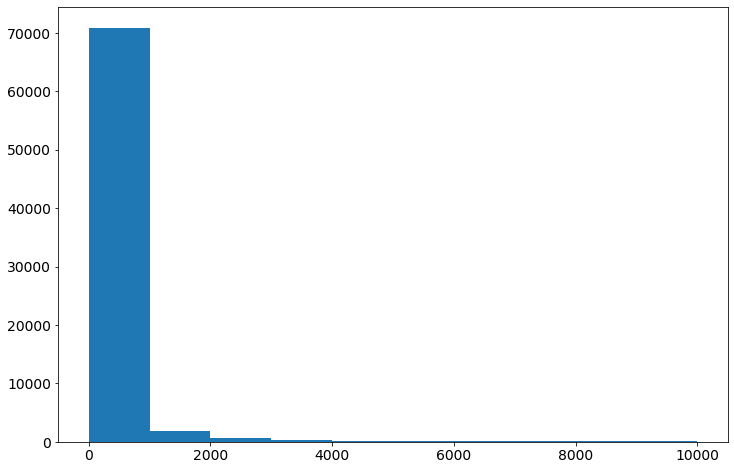

In [118]:
plt.hist(np.exp(X_params_train[:,energy_idx]))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))

z2 = np.concatenate([z.T, z.T]).T
xs2 = np.concatenate([xs, xs + 2*np.pi])

im = ax.imshow(np.log(z2), extent=(xs2[0], xs2[-1], ys[0], ys[-1]), origin='lower', cmap='Spectral_r', aspect='auto')
ax.axvline(true_x, c='r')
ax.axhline(true_y, c='r', label='truth')

plt.colorbar(im, ax=ax, label='learned log-likelihood', )

plt.contour(xs2, ys, np.log(z2), [-9.21/2, -5.99/2, -4.51/2, -2.3/2], colors='w')

plt.plot(xx[np.argmax(z)],  yy[np.argmax(z)], marker='*', color='w', lw=0, ms=20, label='MLE')

plt.plot(r_test[event_idx][0],  r_test[event_idx][1], marker='o', color='k', lw=0, ms=10, label='SPEFit2')


#ax.set_xlabel('x position (m)')
#ax.set_ylabel('y position (m)')

#ax.set_xlabel('x position (m)')
#ax.set_ylabel('z position (m)')

ax.set_xlabel('azimuth (rad)')
ax.set_ylabel('zenith (rad)')

plt.legend()

#plt.savefig('x-y_vertex_evnt%i.png'%event_idx, dpi=150)